<a href="https://colab.research.google.com/github/KalharaBatangala/BrainTumorPrediction-ResNet50/blob/main/BrainMRIAnalysis_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# MONAI is a medical imaging library—widely used in research for BraTS handling (e.g., in MICCAI papers). It auto-downloads BraTS.
#!pip install monai torch torchvision numpy matplotlib scikit-learn pyyaml  # scikit-learn for metrics; yaml optional for config saving.

INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.6/766.6 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!mkdir -p /content/drive/MyDrive/Research/brain_tumor_dataset
# This line is for creating a folder inside google drive
print("Hello world")

Hello world


In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
import torch
#print('device', torch.cuda.get_device_name())
#print(torch.cuda.device_memory_used())

Image counts per class (Training):
glioma: 1321 images
meningioma: 1339 images
notumor: 1595 images
pituitary: 1457 images


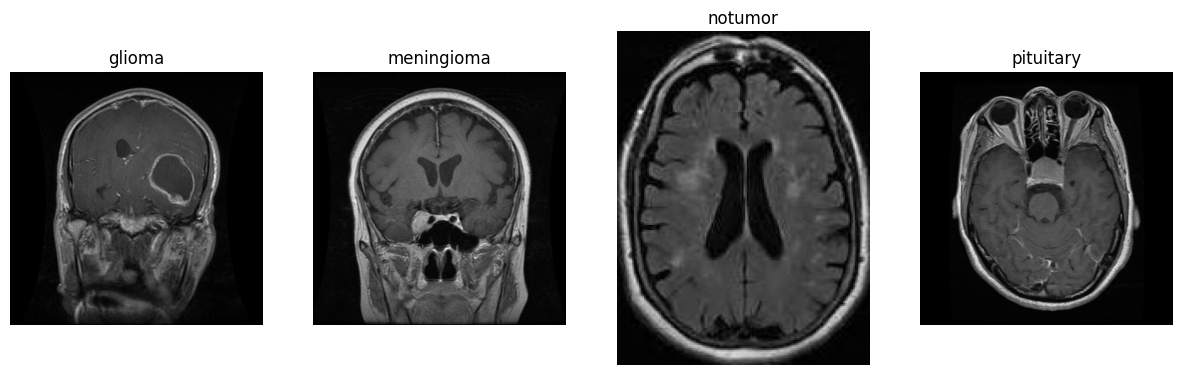

In [4]:
# Verify folder structure and count images.
data_dir = '/content/drive/MyDrive/Research/brain_tumor_dataset/'
base_path = os.path.join(data_dir, 'Training')
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']  # 4 classes
print("Image counts per class (Training):")
for cls in classes:
    cls_path = os.path.join(base_path, cls)
    if os.path.exists(cls_path):
        count = len([f for f in os.listdir(cls_path) if f.endswith(('.jpg', '.png'))])
        print(f"{cls}: {count} images")
    else:
        print(f"{cls}: Folder not found")

# Visualize one image per class.
plt.figure(figsize=(15, 5))
for i, cls in enumerate(classes):
    cls_path = os.path.join(base_path, cls)
    if os.path.exists(cls_path):
        img_files = [f for f in os.listdir(cls_path) if f.endswith(('.jpg', '.png'))]
        if img_files:
            img_path = os.path.join(cls_path, img_files[0])
            img = Image.open(img_path)
            plt.subplot(1, 4, i+1)
            plt.imshow(img, cmap='gray')  # Grayscale, assuming single-modality.
            plt.title(cls)
            plt.axis('off')
        else:
            print(f"No images found in {cls}")
plt.show()

Image counts per class (Testing):
glioma: 300 images
meningioma: 306 images
notumor: 405 images
pituitary: 300 images


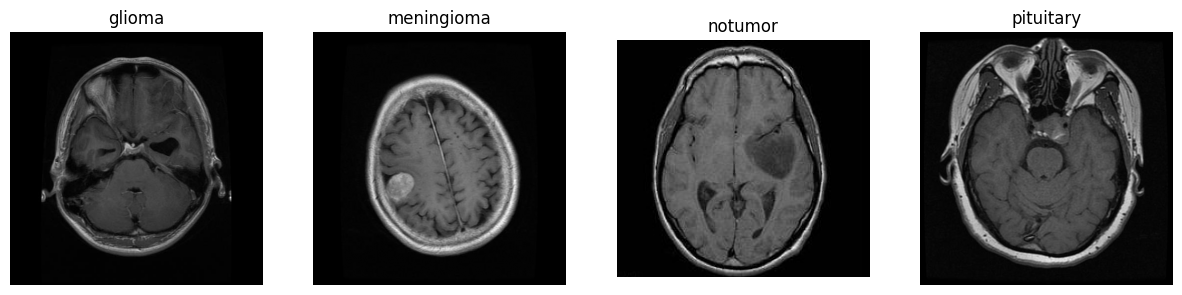

In [5]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Count images in Testing folder.
data_dir = '/content/drive/MyDrive/Research/brain_tumor_dataset'  # Adjust if nested.
base_path = os.path.join(data_dir, 'Testing')
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']  # Match folder names.
print("Image counts per class (Testing):")
for cls in classes:
    cls_path = os.path.join(base_path, cls)
    if os.path.exists(cls_path):
        count = len([f for f in os.listdir(cls_path) if f.endswith(('.jpg', '.png'))])
        print(f"{cls}: {count} images")
    else:
        print(f"{cls}: Folder not found")

# Visualize one image per class with contrast adjustment.
plt.figure(figsize=(15, 5))
for i, cls in enumerate(classes):
    cls_path = os.path.join(base_path, cls)
    if os.path.exists(cls_path):
        img_files = [f for f in os.listdir(cls_path) if f.endswith(('.jpg', '.png'))]
        if img_files:
            img_path = os.path.join(cls_path, img_files[0])
            img = Image.open(img_path)
            img_np = np.array(img)
            img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)  # Normalize for contrast.
            plt.subplot(1, 4, i+1)
            plt.imshow(img_np, cmap='gray')
            plt.title(cls)
            plt.axis('off')
        else:
            print(f"No images found in {cls}")
plt.show()

In [8]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Define paths to your dataset in Drive (adjust if needed).
train_dir = '/content/drive/MyDrive/Research/brain_tumor_dataset/Training'
test_dir = '/content/drive/MyDrive/Research/brain_tumor_dataset/Testing'

# Basic transforms (placeholder; we'll enhance later for high performance).
# Pros start simple: Resize to 224x224 (ResNet50 input), convert to tensor, normalize with ImageNet stats for transfer learning.
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to ResNet50 size.
    transforms.ToTensor(),  # Convert to PyTorch tensor (channels first).
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet norms for pre-trained ResNet50.
])

# Load Training data with ImageFolder (auto-labels classes: 0=glioma, 1=meningioma, 2=no_tumor, 3=pituitary).
# Pros use this for folder-based datasets like yours—saves manual labeling.
train_dataset = datasets.ImageFolder(train_dir, transform=transform)

# Split Training into train (80%) and val (20%) for tuning (best practice to avoid overfitting).
# random_split ensures randomness; val set helps monitor performance during training.
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Load Testing data (no split needed).
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Create DataLoaders for efficient batching.
# shuffle=True for training (randomizes order); num_workers=2 for Colab speed; batch_size=32 (balance memory/performance).
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

# Print details for verification (pros always check sizes).
print(f"Train size: {len(train_dataset)} | Val size: {len(val_dataset)} | Test size: {len(test_dataset)}")
print(f"Classes: {train_dataset.dataset.classes}")  # Shows ['glioma', 'meningioma', 'no_tumor', 'pituitary']

Train size: 4569 | Val size: 1143 | Test size: 1311
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


Train size: 4569 | Val size: 1143 | Test size: 1311
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


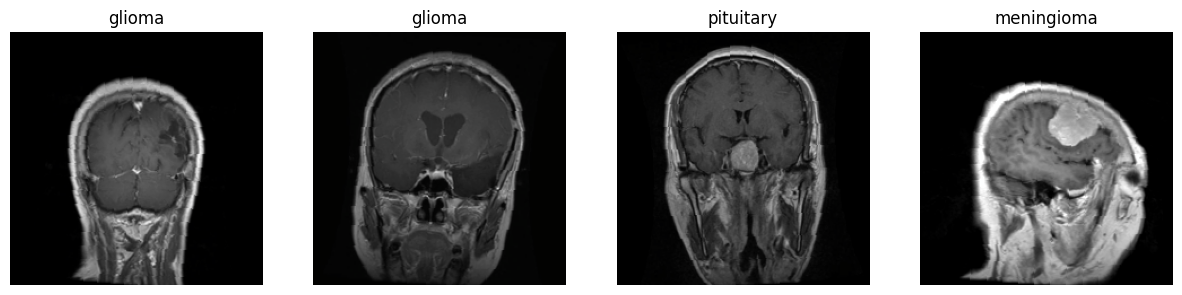

In [25]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Define enhanced transforms for training (with augmentation) and val/test (minimal).
# Pros use separate transforms: augmentation for train, only preprocessing for val/test.
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to ResNet50 input size.
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance to flip horizontally (mimics MRI orientations).
    transforms.RandomRotation(degrees=10),  # ±10° rotation (handles patient positioning).
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness/contrast (mimics scanner differences).
    transforms.ToTensor(),  # Convert to tensor (channels first).
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet norms for ResNet50.
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Same resize for consistency.
    transforms.ToTensor(),  # Convert to tensor.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Same normalization.
])

# Load datasets with new transforms.
train_dir = '/content/drive/MyDrive/Research/brain_tumor_dataset/Training'
test_dir = '/content/drive/MyDrive/Research/brain_tumor_dataset/Testing'

# ImageFolder for automatic labeling (0=glioma, 1=meningioma, 2=notumor, 3=pituitary).
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transforms)

# Split Training into train (80%) and val (20%).
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# DataLoaders for batching.
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

# Verify setup.
print(f"Train size: {len(train_dataset)} | Val size: {len(val_dataset)} | Test size: {len(test_dataset)}")
print(f"Classes: {train_dataset.dataset.classes}")

# Visualize one batch from train_loader to check augmentation (optional, for learning).
images, labels = next(iter(train_loader))  # Get one batch.
class_names = train_dataset.dataset.classes
plt.figure(figsize=(15, 5))
for i in range(4):  # Show 4 images.
    plt.subplot(1, 4, i+1)
    img = images[i].permute(1, 2, 0).numpy()  # Convert tensor to HxWxC for plotting.
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Denormalize.
    img = np.clip(img, 0, 1)  # Ensure valid pixel values.
    plt.imshow(img, cmap='gray')  # Grayscale for T2-weighted.
    plt.title(class_names[labels[i].item()])
    plt.axis('off')
plt.show()

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score

# Set device (GPU if available, else CPU). Pros use GPU for speed in medical imaging.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load pre-trained ResNet50 (ImageNet weights).
# In medical imaging, transfer learning leverages pre-trained features for small datasets like yours (~7,000 images).
model = models.resnet50(pretrained=True)  # Loads pre-trained ResNet50.

# Freeze pre-trained layers to preserve ImageNet weights (pros fine-tune selectively for small datasets).
for param in model.parameters():
    param.requires_grad = False

# Modify final fully connected layer for 4 classes (glioma, meningioma, notumor, pituitary).
# ResNet50's default is 1,000 classes; we change to 4 for your task.
num_classes = 4
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Replace final layer.

# Unfreeze final layer for fine-tuning (pros train only the new layer initially for stability).
model.fc.requires_grad = True

# Move model to GPU/CPU.
model = model.to(device)

# Define loss function (CrossEntropyLoss for multi-class; handles mild imbalance for now).
criterion = nn.CrossEntropyLoss()

# Define optimizer (Adam is common for fine-tuning in medical imaging).
# Low learning rate (0.001) preserves pre-trained weights while adapting to MRIs.
optimizer = optim.Adam(model.fc.parameters(), lr=0.0005)

# Verify model setup.
print("Final layer of ResNet50:")
print(model.fc)  # Should show: Linear(in_features=2048, out_features=4, bias=True)
print(f"Model is on device: {next(model.parameters()).device}")

Using device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Final layer of ResNet50:
Linear(in_features=2048, out_features=4, bias=True)
Model is on device: cuda:0


In [23]:
# Define training/validation function.
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()  # Set model to training mode.
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move to GPU.
        optimizer.zero_grad()  # Clear gradients.
        outputs = model(images)  # Forward pass: predict.
        loss = criterion(outputs, labels)  # Compute loss.
        loss.backward()  # Backpropagation.
        optimizer.step()  # Update weights.
        running_loss += loss.item() * images.size(0)  # Total loss.
        _, preds = torch.max(outputs, 1)  # Predicted classes.
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc

def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()  # Set model to evaluation mode.
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No gradients for validation.
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc

# Verify setup (no training yet).
print(f"Train size: {len(train_dataset)} | Val size: {len(val_dataset)} | Test size: {len(test_dataset)}")
print(f"Classes: {train_dataset.dataset.classes}")
print(f"Model final layer: {model.fc}")
print(f"Model device: {next(model.parameters()).device}")

Train size: 4569 | Val size: 1143 | Test size: 1311
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Model final layer: Linear(in_features=2048, out_features=4, bias=True)
Model device: cuda:0


In [28]:
# Train for 5 epochs (pros start small to check performance).
num_epochs = 15
print("Epoch | Train Loss | Train Acc | Val Loss | Val Acc")
for epoch in range(num_epochs):
    # Train one epoch.
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    # Validate one epoch.
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)
    # Print results.
    print(f"{epoch+1}    | {train_loss:.4f}    | {train_acc:.4f}  | {val_loss:.4f}  | {val_acc:.4f}")

Epoch | Train Loss | Train Acc | Val Loss | Val Acc
1    | 0.7503    | 0.7172  | 0.4538  | 0.8574
2    | 0.5540    | 0.7969  | 0.4360  | 0.8346
3    | 0.5132    | 0.7973  | 0.3682  | 0.8775
4    | 0.4765    | 0.8229  | 0.3537  | 0.8854
5    | 0.4704    | 0.8236  | 0.3588  | 0.8600
6    | 0.4908    | 0.8214  | 0.3730  | 0.8705
7    | 0.4599    | 0.8238  | 0.3279  | 0.8933
8    | 0.4438    | 0.8337  | 0.4112  | 0.8460
9    | 0.4270    | 0.8424  | 0.3179  | 0.8906
10    | 0.4494    | 0.8306  | 0.3492  | 0.8696
11    | 0.4358    | 0.8352  | 0.3081  | 0.8976
12    | 0.4398    | 0.8334  | 0.3122  | 0.8924
13    | 0.4057    | 0.8453  | 0.2772  | 0.9073
14    | 0.4119    | 0.8466  | 0.3522  | 0.8845
15    | 0.3945    | 0.8505  | 0.3347  | 0.8801
